In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [210]:
df = pd.read_csv('交通出行优化赛题数据集(交叉口流量).csv',encoding="GBK")

In [211]:
df.head()

,junction_name,junction_approach,veh_turn_dir,phase_id,timestamp,volume
0,青龙港路-民乐路,A,l,7,230612000000,0
1,青龙港路-民乐路,A,r,13,230612000000,3
2,青龙港路-民乐路,B,r,14,230612000000,3
3,青龙港路-民乐路,B,s,2,230612000000,11
4,青龙港路-民乐路,D,l,10,230612000000,6


## Step1 preprocess the data

In [212]:
## preprocess the data
categorical_feature = ['junction_name','phase_id','junction_approach','veh_turn_dir']
def preprocess(df):
    df['timestamp'] = int(20e12)+df['timestamp']
    df['timestamp'] = df['timestamp'].astype('string')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by = ['junction_name','phase_id','timestamp'],inplace = True)
    df.set_index('timestamp',inplace = True)
    ##lgb can only handle categorical features
    for c in categorical_feature:
        df[c] = df[c].astype('category')
    return df

In [213]:
df = preprocess(df)

In [214]:
df.head()

,junction_name,junction_approach,veh_turn_dir,phase_id,volume
timestamp,,,,,
2023-06-12 00:00:00,北天成路-吴韵路,A,s,1,0
2023-06-12 00:15:00,北天成路-吴韵路,A,s,1,0
2023-06-12 00:30:00,北天成路-吴韵路,A,s,1,0
2023-06-12 00:45:00,北天成路-吴韵路,A,s,1,0
2023-06-12 01:00:00,北天成路-吴韵路,A,s,1,0


## Step2 basic EDA

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 227430 entries, 2023-06-12 00:00:00 to 2023-07-02 23:45:00
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   junction_name      227430 non-null  category
 1   junction_approach  227430 non-null  category
 2   veh_turn_dir       227430 non-null  category
 3   phase_id           227430 non-null  category
 4   volume             227430 non-null  int64   
dtypes: category(4), int64(1)
memory usage: 4.3 MB


In [216]:
df.junction_name.nunique(),df.junction_approach.nunique(),df.veh_turn_dir.nunique(),df.phase_id.nunique()

(13, 4, 3, 12)

In [217]:
# ##time range
# df.timestamp.min(),df.timestamp.max()

In [218]:
df[['junction_name','phase_id']].value_counts()

junction_name  phase_id
北天成路-吴韵路       1           1995
青龙港路-城通路       4           1995
青龙港路-吴韵路       14          1995
               13          1995
               10          1995
                           ... 
城通路-南天成路       15          1995
               14          1995
               13          1995
               10          1995
青龙港路-相城大道      16          1995
Length: 114, dtype: int64

In [219]:
df.groupby(['junction_name','junction_approach','veh_turn_dir']).nunique()

phase_id  volume
junction_name junction_approach veh_turn_dir                  
北天成路-吴韵路      A                 l                    1       6
                                r                    1       6
                                s                    1       6
              B                 l                    1      29
                                r                    1      20
...                                                ...     ...
青龙港路-相城大道     C                 r                    1     127
                                s                    1     165
              D                 l                    1      71
                                r                    1      73
                                s                    1      68

[156 rows x 2 columns]

In [220]:
df.groupby(["junction_name"]).agg({"volume": ["count","sum", "mean", "median", "std", "min", "max"]})

volume                                              
               count     sum       mean median        std min  max
junction_name                                                     
北天成路-吴韵路       23940   54928   2.294403    1.0   3.982968   0   45
南天成路-吴韵路       23940  265924  11.107937    4.0  20.066635   0  181
城通路-南天成路       23940  452971  18.921094    9.0  24.067252   0  158
民乐路-南天成路       23940  281234  11.747452    5.0  19.475298   0  186
水景路-南天成路       23940  338871  14.155013    7.0  21.907613   0  175
水景路-青龙港路       11970  216776  18.109942   11.0  20.921481   0  146
采莲路-青龙港路       11970  132133  11.038680    4.0  16.894450   0  174
青龙港路-云集街       11970  157929  13.193734    4.0  20.736755   0  155
青龙港路-吴韵路       11970  236703  19.774687   11.0  24.713973   0  168
青龙港路-城通路       11970  221384  18.494904   13.0  18.306390   0  117
青龙港路-民乐路       11970  273586  22.855973   13.0  26.526765   0  166
青龙港路-汇流街       11970  183599  15.338262    6.0  22.300864   0  168
青龙港路-相城大道      23940  524582  21.912364    9.0  27.735926   0  227

In [221]:
df.groupby(["junction_name",'junction_approach','veh_turn_dir']).agg({"volume": ["count","sum", "mean", "median", "std", "min", "max"]})

volume                            \
                                              count     sum       mean median   
junction_name junction_approach veh_turn_dir                                    
北天成路-吴韵路      A                 l              1995     808   0.405013    0.0   
                                r              1995     450   0.225564    0.0   
                                s              1995     937   0.469674    0.0   
              B                 l              1995    9103   4.562907    3.0   
                                r              1995    1531   0.767419    0.0   
...                                             ...     ...        ...    ...   
青龙港路-相城大道     C                 r              1995   79377  39.787970   43.0   
                                s              1995  101508  50.881203   55.0   
              D                 l              1995   16112   8.076190    5.0   
                                r              1995   18619   9.332832    5.0   
                                s              1995   25011  12.536842   11.0   

                                                                     
                                                    std  min    max  
junction_name junction_approach veh_turn_dir                         
北天成路-吴韵路      A                 l              0.748368  0.0    5.0  
                                r              0.515797  0.0    5.0  
                                s              0.788876  0.0    5.0  
              B                 l              4.826314  0.0   36.0  
                                r              2.134411  0.0   37.0  
...                                                 ...  ...    ...  
青龙港路-相城大道     C                 r             28.102329  0.0  159.0  
                                s             37.439921  0.0  227.0  
              D                 l             11.028058  0.0   90.0  
                                r             12.918326  0.0  106.0  
                                s             12.165402  0.0   83.0  

[156 rows x 7 columns]

In [222]:
##junction_name like store, phase id like item, 13 store, each has 12 items, we predict future sales of items at different store
# Summary Stats for each item
df.groupby(["phase_id"]).agg({"volume": ["count","sum", "mean", "median", "std", "min", "max"]})

volume                                              
          count     sum       mean median        std min  max
phase_id                                                     
1         11970  132319  11.054219    3.0  22.230700   0  172
2         25935  881409  33.985309   28.0  30.667002   0  186
3         11970  146368  12.227903    3.0  23.675011   0  227
4         25935  834198  32.164951   24.0  30.700318   0  181
7         23940  142604   5.956725    3.0   7.957512   0   86
8         13965  248604  17.801933   11.0  19.503167   0  112
9         13965   77665   5.561404    3.0   7.383966   0   74
10        23940  197005   8.229114    5.0   9.975923   0   90
13        23940  218019   9.106892    5.0  10.987576   0  168
14        23940  215595   9.005639    4.0  15.201654   0  127
15        13965  176378  12.630004    7.0  17.927871   0  174
16        13965   70456   5.045184    3.0   7.135873   0  106

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 227430 entries, 2023-06-12 00:00:00 to 2023-07-02 23:45:00
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   junction_name      227430 non-null  category
 1   junction_approach  227430 non-null  category
 2   veh_turn_dir       227430 non-null  category
 3   phase_id           227430 non-null  category
 4   volume             227430 non-null  int64   
dtypes: category(4), int64(1)
memory usage: 4.3 MB


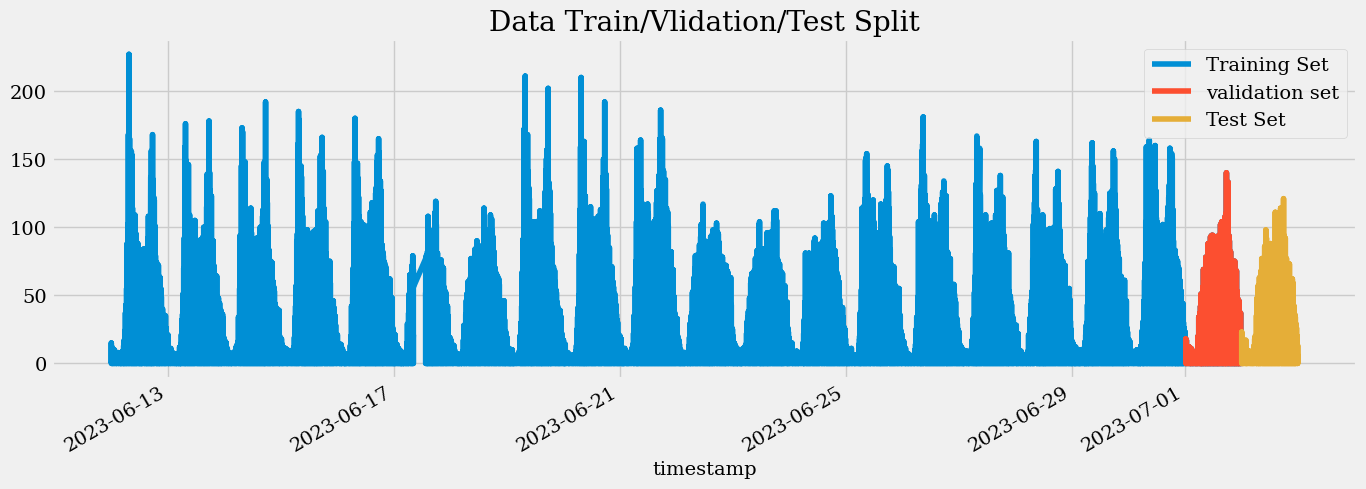

In [224]:
##明确目的，我们利用20天的训练数据，1天作为验证数据，
# df.set_index('timestamp',inplace = True)
# train = df[df.index < '2023-07-02']
# test = df[df.index >= '2023-07-02']
train = df.loc[df.index < '2023-07-02']
validation = df.loc[(df.index < '2023-07-02')&(df.index > '2023-07-01')]
test = df.loc[df.index >= '2023-07-02']

fig, ax = plt.subplots(figsize=(15, 5))
train[['volume']].plot(ax=ax, label='Training Set', title='Data Train/Vlidation/Test Split')
validation[['volume']].plot(ax=ax, label='validation Set')
test[['volume']].plot(ax=ax, label='Test Set')
#ax.axvline('2023-06-29 00:00:00', color='black', ls='--')
ax.legend(['Training Set', 'validation set','Test Set'])
plt.show()

In [225]:
# road_list = list(df.junction_name.unique())
# counter = 0
# fig, axes = plt.subplots(2, 10, figsize=(20, 10))
# for i in road_list:
#     if counter < 10:
#         train[train.junction_name == i].volume.hist(ax=axes[0, counter-1])
#         axes[0,counter-1].set_title("Road " + str(i), fontsize = 15)
#     else:
#         train[train.junction_name == i].volume.hist(ax=axes[1, counter - 6])
#         axes[1,counter-6].set_title("Road " + str(i), fontsize = 15)
#     counter += 1
        
# #plt.tight_layout(pad=4.5)
# plt.suptitle("Histogram: volume");

In [226]:
max(train.index),max(test.index)

(Timestamp('2023-07-01 23:45:00'), Timestamp('2023-07-02 23:45:00'))

In [227]:
train.tail()

,junction_name,junction_approach,veh_turn_dir,phase_id,volume
timestamp,,,,,
2023-07-01 22:45:00,青龙港路-相城大道,D,r,16,0
2023-07-01 23:00:00,青龙港路-相城大道,D,r,16,2
2023-07-01 23:15:00,青龙港路-相城大道,D,r,16,2
2023-07-01 23:30:00,青龙港路-相城大道,D,r,16,0
2023-07-01 23:45:00,青龙港路-相城大道,D,r,16,1


In [228]:
test.head()

,junction_name,junction_approach,veh_turn_dir,phase_id,volume
timestamp,,,,,
2023-07-02 00:00:00,北天成路-吴韵路,A,s,1,0
2023-07-02 00:15:00,北天成路-吴韵路,A,s,1,0
2023-07-02 00:30:00,北天成路-吴韵路,A,s,1,0
2023-07-02 00:45:00,北天成路-吴韵路,A,s,1,0
2023-07-02 01:00:00,北天成路-吴韵路,A,s,1,0


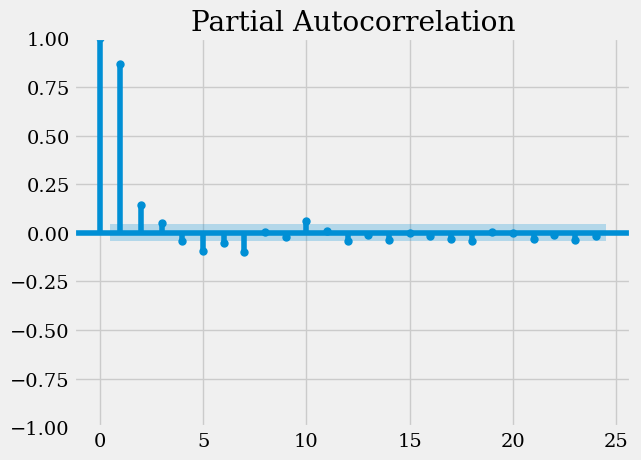

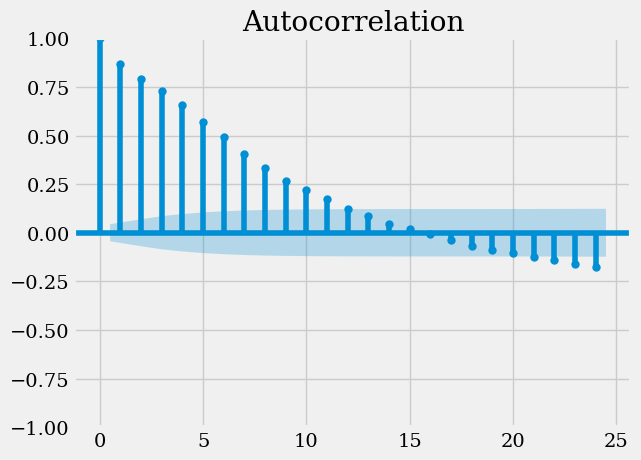

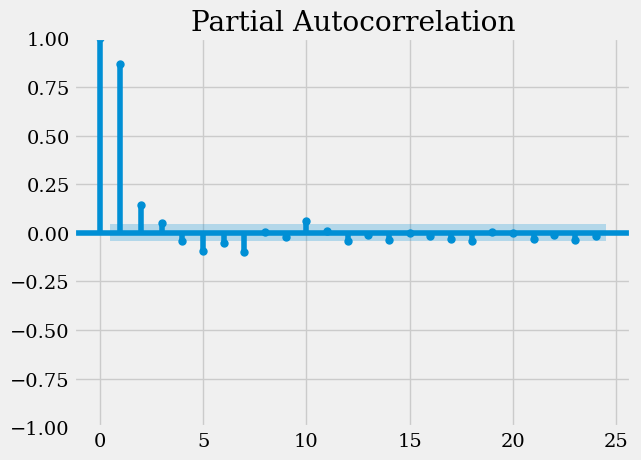

In [229]:
## There is more than one way of determining the lag at which the correlation is significant. For instance, we can use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots.

#ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
#PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons#
#The partial autocorrelation function shows a high correlation with the first lag and lesser correlation with the second and third lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df[(df.junction_name == '青龙港路-民乐路')&(df.phase_id == 13)].volume, lags=24)
plot_pacf(df[(df.junction_name == '青龙港路-民乐路')&(df.phase_id == 13)].volume, lags=24)

## Step3 Feature Egineering

In [230]:
## feature engineering
def get_date_features(df):
    """create time features based on time series index

    Args:
        df (_type_): _description_
    """
    df = df.copy()
    df['hour'] = df.index.hour
    ## create go to work and go back home peak feature
    df['go_to_work_peak'] = ((df['hour']>=7)&(df['hour']<=9)).astype('int')
    df['go_back_home_peak'] = ((df['hour']>=17)&(df['hour']<=19)).astype('int')
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype('int')
    df['is_weekend'] = (df.index.dayofweek > 4).astype('int')
    return df

In [231]:
def get_basic_lag_features(df):
    lags = 12
    for i in range(lags):
        df['volume_lag_{}'.format(i+1)] = df.groupby(["junction_name", "phase_id"])[["volume"]].shift(i+1)
    return df
    

In [232]:
def get_rolling_window_features(df):
    window = 4
    df['volume_rolling_sum_{}'.format(window)] = df.groupby(["junction_name", "phase_id"])[["volume"]].rolling(window=window).sum().reset_index(drop=True).volume.values
    df['volume_rolling_mean_{}'.format(window)] = df.groupby(["junction_name", "phase_id"])[["volume"]].rolling(window=window).mean().reset_index(drop=True).volume.values
    df['volume_rolling_std_{}'.format(window)] = df.groupby(["junction_name", "phase_id"])[["volume"]].rolling(window=window).std().reset_index(drop=True).volume.values
    df['volume_rolling_skew_{}'.format(window)] = df.groupby(["junction_name", "phase_id"])[["volume"]].rolling(window=window).skew().reset_index(drop=True).volume.values
    return df


In [233]:
def get_expand_window_features(df):
    window = 2
    #df['volume_expand_sum'] = df.expanding(window).volume.sum()
    df['volume_expand_mean'] = df.groupby(["junction_name", "phase_id"])[["volume"]].expanding(window).volume.mean().reset_index().volume.values
    df['volume_expand_std'] = df.groupby(["junction_name", "phase_id"])[["volume"]].expanding(window).volume.std().reset_index().volume.values
    df['volume_expand_skew'] = df.groupby(["junction_name", "phase_id"])[["volume"]].expanding(window).volume.skew().reset_index().volume.values
    return df

In [234]:
def feature_engineering_pipeline(df):
     # Add date features 
     df = get_date_features(df)
     # add basic lag features
     df = get_basic_lag_features(df)
     # add rolling window features
     df = get_rolling_window_features(df)
     # add expanding features
     df = get_expand_window_features(df)
     return df
    

In [235]:
# df[['volume_lag_1', 'volume_lag_2', 'volume_lag_3',
#        'volume_lag_4', 'volume_lag_5', 'volume_lag_6', 'volume_lag_7',
#        'volume_lag_8', 'volume_lag_9', 'volume_lag_10', 'volume_lag_11',
#        'volume_lag_12', 'volume_rolling_sum_4', 'volume_rolling_mean_4',
#        'volume_rolling_std_4', 'volume_rolling_skew_4', 'volume_expand_mean',
#        'volume_expand_std', 'volume_expand_skew']].info()

In [236]:
## set training set and test set
split_date = '2023-07-02'
df = feature_engineering_pipeline(df)
train = df.loc[df.index < '2023-07-02']
test = df.loc[df.index >= '2023-07-02']


In [237]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216600 entries, 2023-06-12 00:00:00 to 2023-07-01 23:45:00
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   junction_name          216600 non-null  category
 1   junction_approach      216600 non-null  category
 2   veh_turn_dir           216600 non-null  category
 3   phase_id               216600 non-null  category
 4   volume                 216600 non-null  int64   
 5   hour                   216600 non-null  int64   
 6   go_to_work_peak        216600 non-null  int64   
 7   go_back_home_peak      216600 non-null  int64   
 8   day_of_week            216600 non-null  int64   
 9   quarter                216600 non-null  int64   
 10  month                  216600 non-null  int64   
 11  day_of_year            216600 non-null  int64   
 12  day_of_month           216600 non-null  int64   
 13  week_of_year           216600 non-null  

In [238]:
train.dropna(inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215232 entries, 2023-06-12 03:00:00 to 2023-07-01 23:45:00
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   junction_name          215232 non-null  category
 1   junction_approach      215232 non-null  category
 2   veh_turn_dir           215232 non-null  category
 3   phase_id               215232 non-null  category
 4   volume                 215232 non-null  int64   
 5   hour                   215232 non-null  int64   
 6   go_to_work_peak        215232 non-null  int64   
 7   go_back_home_peak      215232 non-null  int64   
 8   day_of_week            215232 non-null  int64   
 9   quarter                215232 non-null  int64   
 10  month                  215232 non-null  int64   
 11  day_of_year            215232 non-null  int64   
 12  day_of_month           215232 non-null  int64   
 13  week_of_year           215232 non-null  

In [239]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10830 entries, 2023-07-02 00:00:00 to 2023-07-02 23:45:00
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   junction_name          10830 non-null  category
 1   junction_approach      10830 non-null  category
 2   veh_turn_dir           10830 non-null  category
 3   phase_id               10830 non-null  category
 4   volume                 10830 non-null  int64   
 5   hour                   10830 non-null  int64   
 6   go_to_work_peak        10830 non-null  int64   
 7   go_back_home_peak      10830 non-null  int64   
 8   day_of_week            10830 non-null  int64   
 9   quarter                10830 non-null  int64   
 10  month                  10830 non-null  int64   
 11  day_of_year            10830 non-null  int64   
 12  day_of_month           10830 non-null  int64   
 13  week_of_year           10830 non-null  int64   
 14  is_

In [240]:
def generate_features(train, test):
    
    # Get the time delta between last test and last train observations
    model_delta = max(test.index) - max(train.index)

    # Initialize variables
    lags = [96]
    window = 4
    lag_features = []

    # Concatenate train and test together
    data = pd.concat([train, test], sort=False)

    for lag in lags:
        feat = data.groupby(["junction_name", "phase_id"])[["volume"]].rolling(window=window).mean().shift(lag)
        feat.columns = ['volume_mean_lag_{}'.format(lag)]
        lag_features.append(feat)

        feat = data.groupby(["junction_name", "phase_id"])[["volume"]].rolling(window=window).std().shift(lag)
        feat.columns = ['volume_std_lag_{}'.format(lag)]
        lag_features.append(feat)

    # Concatenate all features together
    lag_features = pd.concat(lag_features, axis=1)

    # Add date features to the train and test
    train = get_date_features(train)
    test = get_date_features(test)

    # Join lag features to the train and test by (store, item, date)
    train.set_index(["junction_name", "phase_id"], append=True, inplace=True)
    train = train.reorder_levels(["junction_name", "phase_id", "timestamp"])
    test.set_index(["junction_name", "phase_id"], append=True, inplace=True)
    test = test.reorder_levels(["junction_name", "phase_id", "timestamp"])

    train = train.join(lag_features)
    test = test.join(lag_features)

    # Resetting index back
    train.reset_index(level=[0, 1], inplace=True)
    test.reset_index(level=[0, 1], inplace=True)
    
    return train, test, model_delta, window

In [241]:
train.head()

,junction_name,junction_approach,veh_turn_dir,phase_id,volume,hour,go_to_work_peak,go_back_home_peak,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,is_weekend,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,volume_lag_10,volume_lag_11,volume_lag_12,volume_rolling_sum_4,volume_rolling_mean_4,volume_rolling_std_4,volume_rolling_skew_4,volume_expand_mean,volume_expand_std,volume_expand_skew
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-12 03:00:00,北天成路-吴韵路,A,s,1,0,3,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-12 03:15:00,北天成路-吴韵路,A,s,1,0,3,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-12 03:30:00,北天成路-吴韵路,A,s,1,0,3,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-12 03:45:00,北天成路-吴韵路,A,s,1,0,3,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-12 04:00:00,北天成路-吴韵路,A,s,1,0,4,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


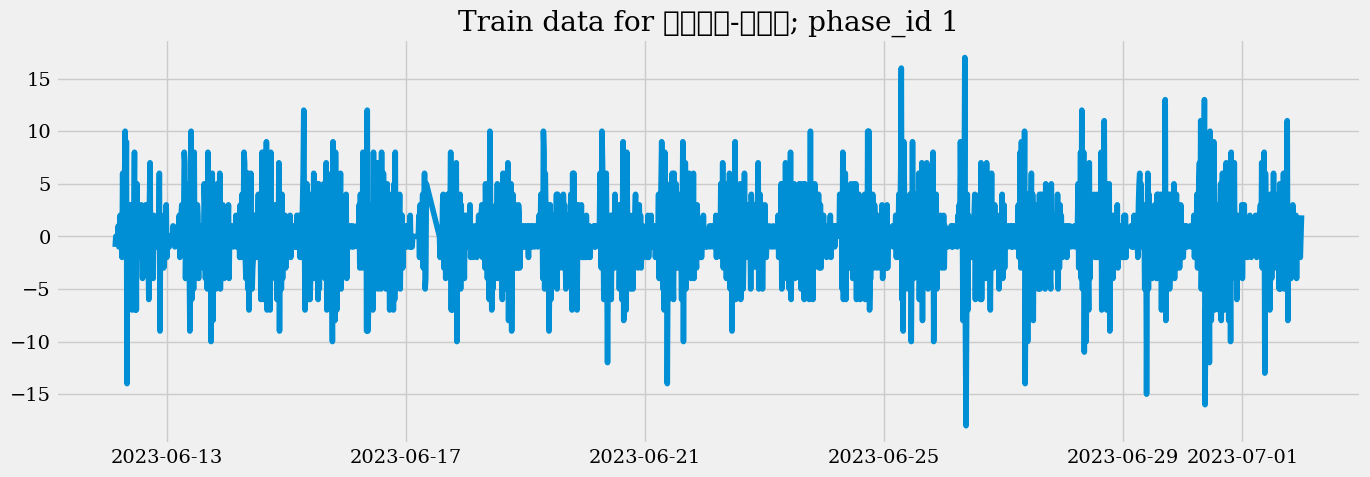

In [242]:
# Look at the data
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.figure(figsize=(15, 5))
plt.plot(train[(train.junction_name=='青龙港路-民乐路') & (train.phase_id==7)]["volume"].diff())
plt.title("Train data for 青龙港路-民乐路; phase_id 1")
plt.show()

In [243]:
# # Train start date
# start = min(train.index) + model_delta + datetime.timedelta(minutes=15*window)

# # Validation start date
model_delta = max(test.index) - max(train.index)
split_date = max(train.index) - model_delta
# print(start,split_date)
# # Keep only non-NA values in the train data
# train = train[train.index >= start]

# Train-Validation split
val_train = train[train.index < split_date]
validation = train[train.index > split_date]

In [244]:
split_date

Timestamp('2023-06-30 23:45:00')

In [245]:
# def smape(y_true, y_pred):
#     denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
#     diff = 100 * np.abs(y_true - y_pred) / denominator
#     diff[denominator == 0] = 0.0
    
#     return np.nanmean(diff)


# def smape_lightgbm(y_pred, y_true):
#     return "smape", smape(y_true, y_pred), False

In [246]:
# Select all the features except for the target variable
features = [x for x in train.columns if x != "volume"]

params = {
    "learning_rate": 0.1,
    "objective": "regression",
    "metric": "None",
    "n_estimators": 1000,
    "colsample_bytree": 0.9,
    "num_leaves": 32,
    "subsample": 0.8,
    "subsample_freq": 1,
    "lambda_l2": 1
}

# Train LightGBM model
reg = lgb.LGBMRegressor(**params)
reg = reg.fit(
    val_train[features],
    val_train["volume"],
    eval_set=[(validation[features], validation["volume"])],
    verbose=100,
    early_stopping_rounds=500,
    eval_metric='mae',
)

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[100]	valid_0's l1: 1.27285
[200]	valid_0's l1: 0.777741
[300]	valid_0's l1: 0.552129
[400]	valid_0's l1: 0.430685
[500]	valid_0's l1: 0.369376
[600]	valid_0's l1: 0.324213
[700]	valid_0's l1: 0.296838
[800]	valid_0's l1: 0.277654
[900]	valid_0's l1: 0.264736
[1000]	valid_0's l1: 0.254904


In [247]:
predictions = reg.predict(validation[features])
validation['pred'] = predictions
print("Validation MAE: {:.3f}".format(mean_absolute_error(validation["volume"], validation["pred"])))


Validation MAE: 0.255


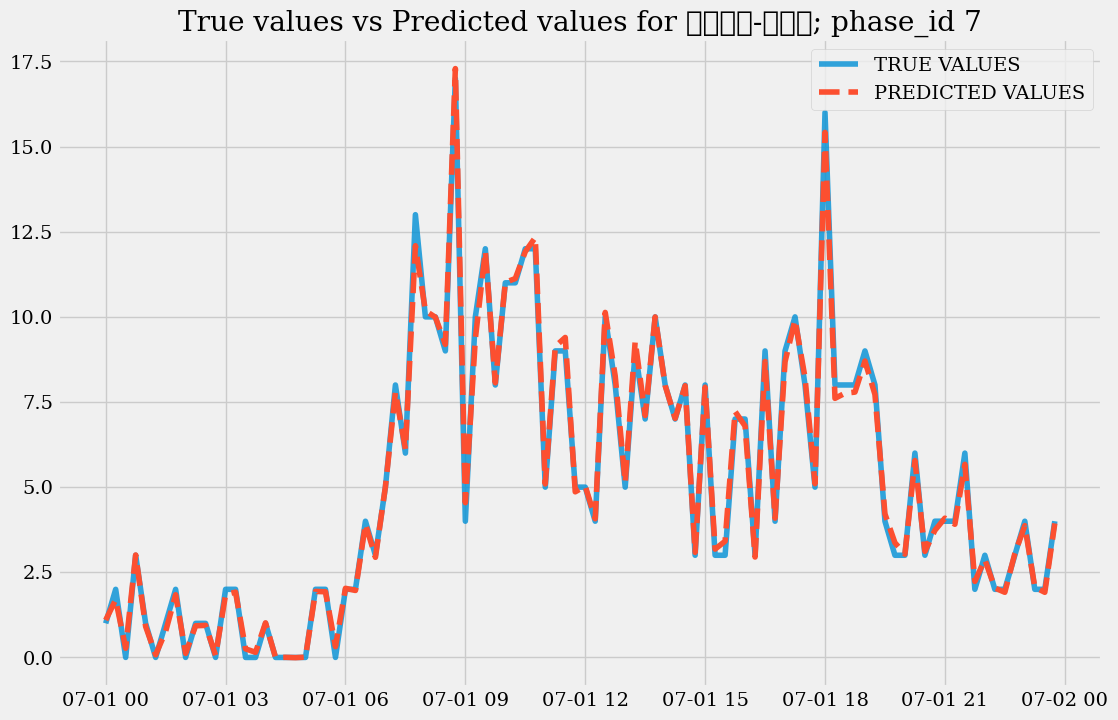

In [248]:
plt.figure(figsize=(12, 8))

to_plot = validation[(validation.junction_name=='青龙港路-民乐路') & (validation.phase_id==7)]

plt.plot(to_plot["volume"], alpha=0.8)
plt.plot(to_plot["pred"], linestyle="--")
plt.title("True values vs Predicted values for 青龙港路-民乐路; phase_id 7")
plt.legend(["TRUE VALUES", "PREDICTED VALUES"])
plt.xticks(None)
plt.show()

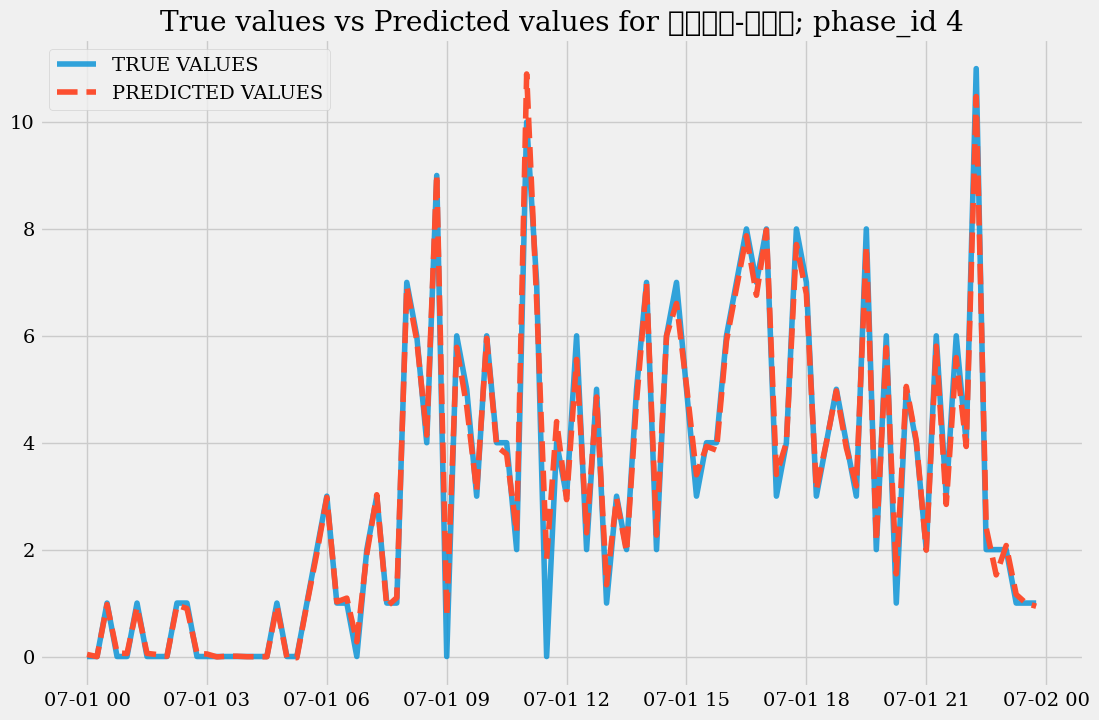

In [249]:
plt.figure(figsize=(12, 8))

to_plot = validation[(validation.junction_name=='北天成路-吴韵路') & (validation.phase_id==4)]

plt.plot(to_plot["volume"], alpha=0.8)
plt.plot(to_plot["pred"], linestyle="--")
plt.title("True values vs Predicted values for 北天成路-吴韵路; phase_id 4")
plt.legend(["TRUE VALUES", "PREDICTED VALUES"])
plt.xticks(None)
plt.show()

In [250]:
##find the best hyperparameters
import optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = lgb.LGBMRegressor(**param)
    model.fit(val_train[features],val_train["volume"])
    y_pred = model.predict(validation[features])
    return mean_absolute_error(validation["volume"], y_pred)

# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)


[I 2023-11-13 11:30:08,472] A new study created in memory with name: regression


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:10,844] Trial 0 finished with value: 0.5812130705619577 and parameters: {'max_depth': 9, 'learning_rate': 0.9981048397075355, 'n_estimators': 361, 'min_child_weight': 10, 'gamma': 0.7101342810180511, 'subsample': 0.09728216604162392, 'colsample_bytree': 0.4700607455620654, 'reg_alpha': 0.5389164694353544, 'reg_lambda': 0.3108378729854929, 'random_state': 861}. Best is trial 0 with value: 0.5812130705619577.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:13,872] Trial 1 finished with value: 0.5053643094128157 and parameters: {'max_depth': 9, 'learning_rate': 0.898705727389448, 'n_estimators': 548, 'min_child_weight': 5, 'gamma': 0.027442233041436986, 'subsample': 0.5523585221628017, 'colsample_bytree': 0.8899388158073163, 'reg_alpha': 0.6103118270263054, 'reg_lambda': 0.6996031042691205, 'random_state': 945}. Best is trial 1 with value: 0.5053643094128157.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:16,492] Trial 2 finished with value: 0.5203506120205736 and parameters: {'max_depth': 5, 'learning_rate': 0.9031802568253439, 'n_estimators': 555, 'min_child_weight': 2, 'gamma': 0.3197926835370529, 'subsample': 0.7023850565565973, 'colsample_bytree': 0.8867008660359912, 'reg_alpha': 0.011559316415587753, 'reg_lambda': 0.09496240101896586, 'random_state': 299}. Best is trial 1 with value: 0.5053643094128157.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:19,826] Trial 3 finished with value: 0.41468770594704657 and parameters: {'max_depth': 8, 'learning_rate': 0.7358944969487706, 'n_estimators': 587, 'min_child_weight': 2, 'gamma': 0.9991295437278662, 'subsample': 0.8627435924454018, 'colsample_bytree': 0.6793334863085946, 'reg_alpha': 0.5795064410969726, 'reg_lambda': 0.811086803829055, 'random_state': 474}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:21,020] Trial 4 finished with value: 2.9178821986353682 and parameters: {'max_depth': 1, 'learning_rate': 0.4373581667379023, 'n_estimators': 830, 'min_child_weight': 3, 'gamma': 0.5151728760875756, 'subsample': 0.40192593407738353, 'colsample_bytree': 0.0429853627903769, 'reg_alpha': 0.5795661691953109, 'reg_lambda': 0.26965716897942377, 'random_state': 931}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:22,947] Trial 5 finished with value: 2.053413230919073 and parameters: {'max_depth': 2, 'learning_rate': 0.08859951837985583, 'n_estimators': 434, 'min_child_weight': 6, 'gamma': 0.6736535599511171, 'subsample': 0.888382229907432, 'colsample_bytree': 0.5035623183189752, 'reg_alpha': 0.04797690077538794, 'reg_lambda': 0.10277580718862238, 'random_state': 713}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:23,989] Trial 6 finished with value: 0.6510095304467581 and parameters: {'max_depth': 10, 'learning_rate': 0.7525378272985864, 'n_estimators': 143, 'min_child_weight': 8, 'gamma': 0.04441910743174965, 'subsample': 0.7343365937003494, 'colsample_bytree': 0.5463944989718562, 'reg_alpha': 0.9913150645772717, 'reg_lambda': 0.5857446752166935, 'random_state': 475}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:25,694] Trial 7 finished with value: 0.601204522907871 and parameters: {'max_depth': 4, 'learning_rate': 0.38459540839763073, 'n_estimators': 397, 'min_child_weight': 4, 'gamma': 0.7006387100225302, 'subsample': 0.9793619509507961, 'colsample_bytree': 0.44166844910586095, 'reg_alpha': 0.44267674398562773, 'reg_lambda': 0.18387744357736713, 'random_state': 148}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:26,500] Trial 8 finished with value: 0.7726359262379454 and parameters: {'max_depth': 3, 'learning_rate': 0.9887590126252802, 'n_estimators': 188, 'min_child_weight': 1, 'gamma': 0.8558109294535176, 'subsample': 0.7709623914546149, 'colsample_bytree': 0.9557400794889106, 'reg_alpha': 0.749004146717241, 'reg_lambda': 0.17818945241283082, 'random_state': 505}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:28,526] Trial 9 finished with value: 3.0221655428403986 and parameters: {'max_depth': 3, 'learning_rate': 0.6411173035213052, 'n_estimators': 801, 'min_child_weight': 9, 'gamma': 0.3724941781082086, 'subsample': 0.7633416245760094, 'colsample_bytree': 0.010062472305464426, 'reg_alpha': 0.5762675158116723, 'reg_lambda': 0.01863296643137718, 'random_state': 69}. Best is trial 3 with value: 0.41468770594704657.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:33,200] Trial 10 finished with value: 0.3646639526919492 and parameters: {'max_depth': 7, 'learning_rate': 0.6371660789614503, 'n_estimators': 992, 'min_child_weight': 7, 'gamma': 0.8771530749781049, 'subsample': 0.9792129066331945, 'colsample_bytree': 0.6959430212587566, 'reg_alpha': 0.29870988994472497, 'reg_lambda': 0.9892716585859465, 'random_state': 581}. Best is trial 10 with value: 0.3646639526919492.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:37,972] Trial 11 finished with value: 0.3608986968885751 and parameters: {'max_depth': 7, 'learning_rate': 0.6234241214241423, 'n_estimators': 980, 'min_child_weight': 7, 'gamma': 0.9621858006321566, 'subsample': 0.993688698828968, 'colsample_bytree': 0.7065611642588397, 'reg_alpha': 0.24339011071874408, 'reg_lambda': 0.9918640485107263, 'random_state': 574}. Best is trial 11 with value: 0.3608986968885751.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:42,676] Trial 12 finished with value: 0.3775340511216685 and parameters: {'max_depth': 7, 'learning_rate': 0.5632268503649215, 'n_estimators': 979, 'min_child_weight': 7, 'gamma': 0.940927203475916, 'subsample': 0.9510723673759625, 'colsample_bytree': 0.7160656852517571, 'reg_alpha': 0.2477402612509123, 'reg_lambda': 0.9914286768187118, 'random_state': 669}. Best is trial 11 with value: 0.3608986968885751.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:47,228] Trial 13 finished with value: 0.31845630411591946 and parameters: {'max_depth': 7, 'learning_rate': 0.5085474785799181, 'n_estimators': 985, 'min_child_weight': 7, 'gamma': 0.8427833109697118, 'subsample': 0.9990593364843595, 'colsample_bytree': 0.7485377047414483, 'reg_alpha': 0.25225400629049344, 'reg_lambda': 0.9885174087781528, 'random_state': 632}. Best is trial 13 with value: 0.31845630411591946.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:51,134] Trial 14 finished with value: 0.3070280827609217 and parameters: {'max_depth': 6, 'learning_rate': 0.35004725757966176, 'n_estimators': 786, 'min_child_weight': 6, 'gamma': 0.9988822625089129, 'subsample': 0.8617044677543265, 'colsample_bytree': 0.8054121136192669, 'reg_alpha': 0.19738279748393472, 'reg_lambda': 0.8739381400795985, 'random_state': 288}. Best is trial 14 with value: 0.3070280827609217.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:55,084] Trial 15 finished with value: 0.30987900244149935 and parameters: {'max_depth': 6, 'learning_rate': 0.3274756671815775, 'n_estimators': 766, 'min_child_weight': 5, 'gamma': 0.8427374857507772, 'subsample': 0.6300735041485547, 'colsample_bytree': 0.826176284408797, 'reg_alpha': 0.13494169649874677, 'reg_lambda': 0.8426608560761051, 'random_state': 297}. Best is trial 14 with value: 0.3070280827609217.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:30:58,593] Trial 16 finished with value: 0.3106990420385216 and parameters: {'max_depth': 5, 'learning_rate': 0.2998893577307478, 'n_estimators': 726, 'min_child_weight': 5, 'gamma': 0.8157794113999255, 'subsample': 0.5705716026278334, 'colsample_bytree': 0.972964053303146, 'reg_alpha': 0.1503104210800345, 'reg_lambda': 0.8149457736060678, 'random_state': 289}. Best is trial 14 with value: 0.3070280827609217.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:02,243] Trial 17 finished with value: 0.28332831770669964 and parameters: {'max_depth': 6, 'learning_rate': 0.244213712993591, 'n_estimators': 683, 'min_child_weight': 4, 'gamma': 0.9833082941916144, 'subsample': 0.6313089388384864, 'colsample_bytree': 0.8571823218887504, 'reg_alpha': 0.13120562143763073, 'reg_lambda': 0.4731580395085937, 'random_state': 300}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:05,934] Trial 18 finished with value: 0.3094384938751822 and parameters: {'max_depth': 6, 'learning_rate': 0.21588737716999054, 'n_estimators': 665, 'min_child_weight': 4, 'gamma': 0.9774678267357414, 'subsample': 0.4647764287729603, 'colsample_bytree': 0.9912540166844904, 'reg_alpha': 0.3591765043736338, 'reg_lambda': 0.45750247276348543, 'random_state': 179}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:09,754] Trial 19 finished with value: 1.1981234443335824 and parameters: {'max_depth': 4, 'learning_rate': 0.03726832927764509, 'n_estimators': 846, 'min_child_weight': 4, 'gamma': 0.999054724159376, 'subsample': 0.832130038631478, 'colsample_bytree': 0.8383749130971402, 'reg_alpha': 0.12022911644628331, 'reg_lambda': 0.4859291408881466, 'random_state': 364}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:12,743] Trial 20 finished with value: 0.39313288863242385 and parameters: {'max_depth': 4, 'learning_rate': 0.20565487536526714, 'n_estimators': 675, 'min_child_weight': 6, 'gamma': 0.7599878603902697, 'subsample': 0.6474293840243709, 'colsample_bytree': 0.6040894225098639, 'reg_alpha': 0.3942700848612535, 'reg_lambda': 0.5825552727277574, 'random_state': 170}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:16,279] Trial 21 finished with value: 0.30445076995716047 and parameters: {'max_depth': 6, 'learning_rate': 0.20886952078945245, 'n_estimators': 634, 'min_child_weight': 4, 'gamma': 0.9301504327847105, 'subsample': 0.4370747932010846, 'colsample_bytree': 0.9976241615198327, 'reg_alpha': 0.3342760757830995, 'reg_lambda': 0.426928833288558, 'random_state': 207}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:19,782] Trial 22 finished with value: 0.288976644364789 and parameters: {'max_depth': 6, 'learning_rate': 0.17113988088444435, 'n_estimators': 635, 'min_child_weight': 3, 'gamma': 0.9167748493257657, 'subsample': 0.387853746932468, 'colsample_bytree': 0.812315174614272, 'reg_alpha': 0.17987615769423276, 'reg_lambda': 0.3735163250247604, 'random_state': 404}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:22,274] Trial 23 finished with value: 0.403699897213701 and parameters: {'max_depth': 5, 'learning_rate': 0.14308778495678504, 'n_estimators': 465, 'min_child_weight': 3, 'gamma': 0.896784494998806, 'subsample': 0.367875381018621, 'colsample_bytree': 0.9950692118910115, 'reg_alpha': 0.33313325276649763, 'reg_lambda': 0.38966623948844836, 'random_state': 392}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:24,434] Trial 24 finished with value: 0.3590360922789672 and parameters: {'max_depth': 8, 'learning_rate': 0.24190477191623028, 'n_estimators': 307, 'min_child_weight': 3, 'gamma': 0.9056544354902489, 'subsample': 0.3234721104180436, 'colsample_bytree': 0.9024902138975586, 'reg_alpha': 0.10703597772173286, 'reg_lambda': 0.39734773946970364, 'random_state': 47}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:28,498] Trial 25 finished with value: 1.2978092042662037 and parameters: {'max_depth': 8, 'learning_rate': 0.018324636707592462, 'n_estimators': 628, 'min_child_weight': 1, 'gamma': 0.7806976110429473, 'subsample': 0.4901415249583925, 'colsample_bytree': 0.9083277688256177, 'reg_alpha': 0.188610652278065, 'reg_lambda': 0.35938966189017746, 'random_state': 403}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:31,506] Trial 26 finished with value: 0.37821390576232966 and parameters: {'max_depth': 6, 'learning_rate': 0.1256647965030279, 'n_estimators': 501, 'min_child_weight': 2, 'gamma': 0.9122948408534024, 'subsample': 0.2688997637059189, 'colsample_bytree': 0.808340299903438, 'reg_alpha': 0.0673522616930523, 'reg_lambda': 0.5424916102820307, 'random_state': 211}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:35,771] Trial 27 finished with value: 0.2908571175527972 and parameters: {'max_depth': 5, 'learning_rate': 0.2677013091859367, 'n_estimators': 874, 'min_child_weight': 4, 'gamma': 0.6370897750180962, 'subsample': 0.4422653239410612, 'colsample_bytree': 0.7891940766678522, 'reg_alpha': 0.29355861849464027, 'reg_lambda': 0.44984408578011115, 'random_state': 102}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:41,845] Trial 28 finished with value: 0.2894648854621378 and parameters: {'max_depth': 5, 'learning_rate': 0.2835687520588769, 'n_estimators': 893, 'min_child_weight': 3, 'gamma': 0.6328930722237198, 'subsample': 0.5214328016182436, 'colsample_bytree': 0.7689555437743646, 'reg_alpha': 0.07320085214803909, 'reg_lambda': 0.48621034515552075, 'random_state': 95}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:44,860] Trial 29 finished with value: 0.3945615515597653 and parameters: {'max_depth': 3, 'learning_rate': 0.4011218902793774, 'n_estimators': 719, 'min_child_weight': 3, 'gamma': 0.7262541645789877, 'subsample': 0.2372332624924191, 'colsample_bytree': 0.6259816030609264, 'reg_alpha': 0.02253663842633033, 'reg_lambda': 0.32643142291925026, 'random_state': 6}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:49,521] Trial 30 finished with value: 0.3034643386954064 and parameters: {'max_depth': 4, 'learning_rate': 0.28865778966969846, 'n_estimators': 923, 'min_child_weight': 2, 'gamma': 0.7830989341399668, 'subsample': 0.5665083594198776, 'colsample_bytree': 0.7554788002150115, 'reg_alpha': 0.07221995054226524, 'reg_lambda': 0.5167625014078226, 'random_state': 342}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:55,086] Trial 31 finished with value: 0.28838991738393416 and parameters: {'max_depth': 5, 'learning_rate': 0.27057813886187804, 'n_estimators': 913, 'min_child_weight': 4, 'gamma': 0.6317640581129225, 'subsample': 0.5004285454053617, 'colsample_bytree': 0.7799462910117951, 'reg_alpha': 0.1811982663812051, 'reg_lambda': 0.4275354141940894, 'random_state': 98}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:31:59,726] Trial 32 finished with value: 0.31098725902501667 and parameters: {'max_depth': 5, 'learning_rate': 0.33664377230759285, 'n_estimators': 902, 'min_child_weight': 3, 'gamma': 0.5990001452588182, 'subsample': 0.512858871901064, 'colsample_bytree': 0.8680618961420491, 'reg_alpha': 0.16050116604506412, 'reg_lambda': 0.30633759447292336, 'random_state': 117}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:05,158] Trial 33 finished with value: 0.2886959432234231 and parameters: {'max_depth': 5, 'learning_rate': 0.1620536200040601, 'n_estimators': 731, 'min_child_weight': 5, 'gamma': 0.6035522909471277, 'subsample': 0.6021992995349521, 'colsample_bytree': 0.853436177647905, 'reg_alpha': 0.09348699758495754, 'reg_lambda': 0.6606547323070903, 'random_state': 247}. Best is trial 17 with value: 0.28332831770669964.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:11,672] Trial 34 finished with value: 0.2804645698218008 and parameters: {'max_depth': 7, 'learning_rate': 0.16269866970384697, 'n_estimators': 737, 'min_child_weight': 5, 'gamma': 0.7655919699527287, 'subsample': 0.6114801948456049, 'colsample_bytree': 0.9084475321194687, 'reg_alpha': 0.013856521718721565, 'reg_lambda': 0.5990167971541552, 'random_state': 237}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:17,372] Trial 35 finished with value: 0.32341680584645804 and parameters: {'max_depth': 9, 'learning_rate': 0.09290749401257148, 'n_estimators': 730, 'min_child_weight': 5, 'gamma': 0.5664824712046381, 'subsample': 0.6371812716279013, 'colsample_bytree': 0.9348206758876703, 'reg_alpha': 0.024747908648001277, 'reg_lambda': 0.6420137298601261, 'random_state': 235}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:22,785] Trial 36 finished with value: 0.30577160874370557 and parameters: {'max_depth': 8, 'learning_rate': 0.14231429548599484, 'n_estimators': 570, 'min_child_weight': 5, 'gamma': 0.7244805796028428, 'subsample': 0.6837986296892964, 'colsample_bytree': 0.8783057932076684, 'reg_alpha': 0.10111518668527562, 'reg_lambda': 0.6905307237722222, 'random_state': 244}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:27,599] Trial 37 finished with value: 0.3019368889379213 and parameters: {'max_depth': 10, 'learning_rate': 0.183323486807622, 'n_estimators': 529, 'min_child_weight': 6, 'gamma': 0.6711313600233251, 'subsample': 0.5932203943398665, 'colsample_bytree': 0.9101277711432966, 'reg_alpha': 0.0231938396599606, 'reg_lambda': 0.6396171670081342, 'random_state': 778}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:32,873] Trial 38 finished with value: 0.2818673129057555 and parameters: {'max_depth': 7, 'learning_rate': 0.25039549509291426, 'n_estimators': 835, 'min_child_weight': 10, 'gamma': 0.5331390446821506, 'subsample': 0.685670629234384, 'colsample_bytree': 0.864739615888052, 'reg_alpha': 0.09839593720872784, 'reg_lambda': 0.5464062739983082, 'random_state': 147}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:38,173] Trial 39 finished with value: 0.29354114889163474 and parameters: {'max_depth': 8, 'learning_rate': 0.262855506347945, 'n_estimators': 836, 'min_child_weight': 10, 'gamma': 0.5281823687490728, 'subsample': 0.6973863905549784, 'colsample_bytree': 0.9308729728104866, 'reg_alpha': 0.2089515614068196, 'reg_lambda': 0.5577585308102417, 'random_state': 29}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:43,034] Trial 40 finished with value: 0.30379742236791385 and parameters: {'max_depth': 9, 'learning_rate': 0.4284378573574076, 'n_estimators': 802, 'min_child_weight': 10, 'gamma': 0.44313456953386376, 'subsample': 0.5402525952508829, 'colsample_bytree': 0.6587981631613273, 'reg_alpha': 0.13346442442758075, 'reg_lambda': 0.736482565235532, 'random_state': 142}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:48,571] Trial 41 finished with value: 0.3409257435434291 and parameters: {'max_depth': 7, 'learning_rate': 0.08679330965798072, 'n_estimators': 743, 'min_child_weight': 8, 'gamma': 0.5655743989335917, 'subsample': 0.6000776550835883, 'colsample_bytree': 0.8648771099599293, 'reg_alpha': 0.09353779670187165, 'reg_lambda': 0.5288059129349764, 'random_state': 246}. Best is trial 34 with value: 0.2804645698218008.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:32:54,505] Trial 42 finished with value: 0.2695116074257356 and parameters: {'max_depth': 7, 'learning_rate': 0.18309836482537645, 'n_estimators': 931, 'min_child_weight': 5, 'gamma': 0.6666460308861187, 'subsample': 0.6744008497923705, 'colsample_bytree': 0.8741829857386927, 'reg_alpha': 0.05804042629558185, 'reg_lambda': 0.5940335407589119, 'random_state': 999}. Best is trial 42 with value: 0.2695116074257356.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:00,684] Trial 43 finished with value: 0.2848594016374927 and parameters: {'max_depth': 7, 'learning_rate': 0.23978102063701487, 'n_estimators': 939, 'min_child_weight': 4, 'gamma': 0.6863332203906661, 'subsample': 0.7368325603770957, 'colsample_bytree': 0.9378276157114236, 'reg_alpha': 0.012361942484980373, 'reg_lambda': 0.6154348292167819, 'random_state': 739}. Best is trial 42 with value: 0.2695116074257356.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:06,082] Trial 44 finished with value: 0.2822071596034221 and parameters: {'max_depth': 7, 'learning_rate': 0.23280138247948162, 'n_estimators': 929, 'min_child_weight': 8, 'gamma': 0.703243066013332, 'subsample': 0.7337075405175321, 'colsample_bytree': 0.952323654855185, 'reg_alpha': 0.01201830624591016, 'reg_lambda': 0.5724489923248216, 'random_state': 918}. Best is trial 42 with value: 0.2695116074257356.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:10,291] Trial 45 finished with value: 0.30887841757659645 and parameters: {'max_depth': 7, 'learning_rate': 0.3599541150281458, 'n_estimators': 852, 'min_child_weight': 9, 'gamma': 0.736484592136971, 'subsample': 0.6790196518657985, 'colsample_bytree': 0.9452052637423882, 'reg_alpha': 0.06493123428141731, 'reg_lambda': 0.5807000012467128, 'random_state': 1000}. Best is trial 42 with value: 0.2695116074257356.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:15,259] Trial 46 finished with value: 0.2643244077802761 and parameters: {'max_depth': 8, 'learning_rate': 0.21272821179255358, 'n_estimators': 940, 'min_child_weight': 10, 'gamma': 0.8375420090617284, 'subsample': 0.7452980372740312, 'colsample_bytree': 0.8807150861959736, 'reg_alpha': 0.04899898378198985, 'reg_lambda': 0.6040678811461015, 'random_state': 885}. Best is trial 46 with value: 0.2643244077802761.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:20,473] Trial 47 finished with value: 0.27034723358770474 and parameters: {'max_depth': 9, 'learning_rate': 0.1975470767554165, 'n_estimators': 952, 'min_child_weight': 8, 'gamma': 0.8015249186414936, 'subsample': 0.7572543478021784, 'colsample_bytree': 0.9001434649147337, 'reg_alpha': 0.010273250485218599, 'reg_lambda': 0.6009753849467576, 'random_state': 875}. Best is trial 46 with value: 0.2643244077802761.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:26,681] Trial 48 finished with value: 0.2516461835734269 and parameters: {'max_depth': 10, 'learning_rate': 0.1034885041362277, 'n_estimators': 985, 'min_child_weight': 9, 'gamma': 0.8138116959313271, 'subsample': 0.7603223087760831, 'colsample_bytree': 0.7321869698302332, 'reg_alpha': 0.05600398351984018, 'reg_lambda': 0.7115082515300309, 'random_state': 855}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:32,557] Trial 49 finished with value: 0.2587448139499794 and parameters: {'max_depth': 10, 'learning_rate': 0.11326916131259443, 'n_estimators': 945, 'min_child_weight': 9, 'gamma': 0.8096025094902435, 'subsample': 0.8074431460955386, 'colsample_bytree': 0.73118918503822, 'reg_alpha': 0.049544781672250945, 'reg_lambda': 0.7131372593224143, 'random_state': 834}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:39,137] Trial 50 finished with value: 0.30102211908274124 and parameters: {'max_depth': 10, 'learning_rate': 0.07172005542473645, 'n_estimators': 965, 'min_child_weight': 9, 'gamma': 0.8044324406556944, 'subsample': 0.8056202110234112, 'colsample_bytree': 0.7143629754413217, 'reg_alpha': 0.054426257545556814, 'reg_lambda': 0.7017779995156104, 'random_state': 841}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:44,947] Trial 51 finished with value: 0.2557158937951758 and parameters: {'max_depth': 10, 'learning_rate': 0.11549473087243582, 'n_estimators': 951, 'min_child_weight': 9, 'gamma': 0.8483499364522322, 'subsample': 0.7828574696120103, 'colsample_bytree': 0.8195078578006251, 'reg_alpha': 0.046664203488199225, 'reg_lambda': 0.7336620650631678, 'random_state': 858}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:45,522] Trial 52 finished with value: 1.7537790221226714 and parameters: {'max_depth': 10, 'learning_rate': 0.11565121575926089, 'n_estimators': 50, 'min_child_weight': 9, 'gamma': 0.8572354713249417, 'subsample': 0.7871706819341386, 'colsample_bytree': 0.742476824283372, 'reg_alpha': 0.05241665419235774, 'reg_lambda': 0.7353687194635421, 'random_state': 865}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:52,127] Trial 53 finished with value: 0.3739448301898441 and parameters: {'max_depth': 9, 'learning_rate': 0.054592285940850735, 'n_estimators': 955, 'min_child_weight': 8, 'gamma': 0.8192326233612086, 'subsample': 0.8971715755395278, 'colsample_bytree': 0.8297978695899793, 'reg_alpha': 0.14460738504303847, 'reg_lambda': 0.7347074366945406, 'random_state': 829}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:33:58,740] Trial 54 finished with value: 0.8619013709749437 and parameters: {'max_depth': 10, 'learning_rate': 0.022078756965228707, 'n_estimators': 998, 'min_child_weight': 9, 'gamma': 0.8643223729693933, 'subsample': 0.7632798576502501, 'colsample_bytree': 0.7415169394782406, 'reg_alpha': 0.22693837268396394, 'reg_lambda': 0.6215531435582307, 'random_state': 900}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:04,251] Trial 55 finished with value: 0.26036479599919793 and parameters: {'max_depth': 9, 'learning_rate': 0.11691804854382704, 'n_estimators': 885, 'min_child_weight': 10, 'gamma': 0.8057594038050658, 'subsample': 0.8204638862006, 'colsample_bytree': 0.7803265614177295, 'reg_alpha': 0.05243726574351455, 'reg_lambda': 0.7756581850331716, 'random_state': 981}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:10,257] Trial 56 finished with value: 0.2666297934066364 and parameters: {'max_depth': 10, 'learning_rate': 0.112360846179587, 'n_estimators': 869, 'min_child_weight': 10, 'gamma': 0.8366131570961557, 'subsample': 0.8212550062646707, 'colsample_bytree': 0.6832320586830646, 'reg_alpha': 0.15203286830993148, 'reg_lambda': 0.7801817284547212, 'random_state': 974}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:16,934] Trial 57 finished with value: 0.26978234681914487 and parameters: {'max_depth': 10, 'learning_rate': 0.09790402090698003, 'n_estimators': 882, 'min_child_weight': 10, 'gamma': 0.9453561064952778, 'subsample': 0.8259095430199869, 'colsample_bytree': 0.6757139726108158, 'reg_alpha': 0.1648505837158537, 'reg_lambda': 0.7911352016704464, 'random_state': 779}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:22,341] Trial 58 finished with value: 0.4125885614561556 and parameters: {'max_depth': 9, 'learning_rate': 0.06308808195885243, 'n_estimators': 802, 'min_child_weight': 10, 'gamma': 0.8716321462633184, 'subsample': 0.8688895102732626, 'colsample_bytree': 0.7150193821898477, 'reg_alpha': 0.1136702784443687, 'reg_lambda': 0.8838027137281484, 'random_state': 969}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:27,523] Trial 59 finished with value: 0.26554838667561975 and parameters: {'max_depth': 9, 'learning_rate': 0.13846022175882058, 'n_estimators': 883, 'min_child_weight': 9, 'gamma': 0.8229013335700085, 'subsample': 0.8032276049325224, 'colsample_bytree': 0.8002039864269341, 'reg_alpha': 0.21725261149523295, 'reg_lambda': 0.7612456239328406, 'random_state': 953}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:34,909] Trial 60 finished with value: 0.41782991238473915 and parameters: {'max_depth': 9, 'learning_rate': 0.04707042368886652, 'n_estimators': 997, 'min_child_weight': 9, 'gamma': 0.8873611243705144, 'subsample': 0.9246158318385641, 'colsample_bytree': 0.7970316892347697, 'reg_alpha': 0.21554757091283863, 'reg_lambda': 0.6730197251111075, 'random_state': 809}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:40,499] Trial 61 finished with value: 0.2538450094730642 and parameters: {'max_depth': 10, 'learning_rate': 0.13854086461804138, 'n_estimators': 867, 'min_child_weight': 10, 'gamma': 0.8265109276942733, 'subsample': 0.836496124848491, 'colsample_bytree': 0.7668238073810534, 'reg_alpha': 0.12871601702000462, 'reg_lambda': 0.7966131003019034, 'random_state': 946}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:42,819] Trial 62 finished with value: 0.4427303470665285 and parameters: {'max_depth': 10, 'learning_rate': 0.1420576795407682, 'n_estimators': 314, 'min_child_weight': 9, 'gamma': 0.8310588675965511, 'subsample': 0.8443812017766029, 'colsample_bytree': 0.8338229588504782, 'reg_alpha': 0.08963545134330128, 'reg_lambda': 0.77368734271214, 'random_state': 944}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:49,992] Trial 63 finished with value: 1.0802513484958507 and parameters: {'max_depth': 9, 'learning_rate': 0.017349389036476884, 'n_estimators': 897, 'min_child_weight': 10, 'gamma': 0.7855062669132344, 'subsample': 0.7985355015733505, 'colsample_bytree': 0.8060067809086022, 'reg_alpha': 0.12966804759168093, 'reg_lambda': 0.7075730892037717, 'random_state': 896}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:34:55,848] Trial 64 finished with value: 0.2761229787080322 and parameters: {'max_depth': 10, 'learning_rate': 0.11400383269232552, 'n_estimators': 775, 'min_child_weight': 9, 'gamma': 0.7471298235425239, 'subsample': 0.8525413638152045, 'colsample_bytree': 0.7485688343611469, 'reg_alpha': 0.04889807358030965, 'reg_lambda': 0.8348309872231445, 'random_state': 927}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:03,240] Trial 65 finished with value: 0.2841639970173417 and parameters: {'max_depth': 8, 'learning_rate': 0.08276134141863367, 'n_estimators': 971, 'min_child_weight': 10, 'gamma': 0.9580448401359656, 'subsample': 0.8911550877256583, 'colsample_bytree': 0.7641331375517683, 'reg_alpha': 0.121080182341528, 'reg_lambda': 0.7626469872436501, 'random_state': 681}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:10,397] Trial 66 finished with value: 0.26354807675347247 and parameters: {'max_depth': 10, 'learning_rate': 0.14567566684064834, 'n_estimators': 822, 'min_child_weight': 8, 'gamma': 0.8883535924133744, 'subsample': 0.786038751000561, 'colsample_bytree': 0.7840230342235519, 'reg_alpha': 0.25268383022643054, 'reg_lambda': 0.6793135264469324, 'random_state': 794}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:16,105] Trial 67 finished with value: 0.2583847170770421 and parameters: {'max_depth': 10, 'learning_rate': 0.21044547073173683, 'n_estimators': 858, 'min_child_weight': 8, 'gamma': 0.8959904957207303, 'subsample': 0.7219474989449169, 'colsample_bytree': 0.650298633747185, 'reg_alpha': 0.17022425939929048, 'reg_lambda': 0.6685591239233802, 'random_state': 738}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:22,222] Trial 68 finished with value: 0.4708149322141773 and parameters: {'max_depth': 10, 'learning_rate': 0.057075914236770296, 'n_estimators': 809, 'min_child_weight': 7, 'gamma': 0.9225924959889477, 'subsample': 0.7249903699037494, 'colsample_bytree': 0.6483788210242535, 'reg_alpha': 0.2519911206415867, 'reg_lambda': 0.6645945567181787, 'random_state': 797}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:27,817] Trial 69 finished with value: 0.25341295761864013 and parameters: {'max_depth': 10, 'learning_rate': 0.17289961138600848, 'n_estimators': 857, 'min_child_weight': 8, 'gamma': 0.8946273399252693, 'subsample': 0.7802343196393022, 'colsample_bytree': 0.6943010710579343, 'reg_alpha': 0.15861421179981433, 'reg_lambda': 0.8195340024678479, 'random_state': 741}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:33,300] Trial 70 finished with value: 0.2808789582658708 and parameters: {'max_depth': 10, 'learning_rate': 0.1688114758567606, 'n_estimators': 862, 'min_child_weight': 7, 'gamma': 0.9480632820265666, 'subsample': 0.9316637830871902, 'colsample_bytree': 0.6198769179240055, 'reg_alpha': 0.18723823248796137, 'reg_lambda': 0.806058876403636, 'random_state': 618}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:38,822] Trial 71 finished with value: 0.26783837579712233 and parameters: {'max_depth': 10, 'learning_rate': 0.12323322893460453, 'n_estimators': 823, 'min_child_weight': 8, 'gamma': 0.8906161822116835, 'subsample': 0.783276836880051, 'colsample_bytree': 0.706411955527631, 'reg_alpha': 0.1562812337409078, 'reg_lambda': 0.7108529965185345, 'random_state': 734}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:44,457] Trial 72 finished with value: 0.2654926711428001 and parameters: {'max_depth': 10, 'learning_rate': 0.15819321831644653, 'n_estimators': 908, 'min_child_weight': 8, 'gamma': 0.8721759604371518, 'subsample': 0.7812373744375639, 'colsample_bytree': 0.5755147621102782, 'reg_alpha': 0.08381214984731229, 'reg_lambda': 0.8212552620713383, 'random_state': 755}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:48,860] Trial 73 finished with value: 0.2625115612833157 and parameters: {'max_depth': 9, 'learning_rate': 0.21574235894951532, 'n_estimators': 775, 'min_child_weight': 9, 'gamma': 0.9037143556920292, 'subsample': 0.8338675413669493, 'colsample_bytree': 0.7735381372566303, 'reg_alpha': 0.2763886656636258, 'reg_lambda': 0.8596473786736771, 'random_state': 678}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:53,664] Trial 74 finished with value: 0.26692526265458094 and parameters: {'max_depth': 9, 'learning_rate': 0.1986009536303823, 'n_estimators': 858, 'min_child_weight': 9, 'gamma': 0.9224993627035617, 'subsample': 0.8293448450031679, 'colsample_bytree': 0.7329312269690728, 'reg_alpha': 0.11842164323808907, 'reg_lambda': 0.8578221596385504, 'random_state': 686}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:35:57,687] Trial 75 finished with value: 0.2866118048362893 and parameters: {'max_depth': 9, 'learning_rate': 0.3141233517732374, 'n_estimators': 767, 'min_child_weight': 9, 'gamma': 0.9767389793374583, 'subsample': 0.7174406189585669, 'colsample_bytree': 0.6926797680412888, 'reg_alpha': 0.17483981476890734, 'reg_lambda': 0.8910821939580893, 'random_state': 839}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:03,588] Trial 76 finished with value: 0.2746292419672129 and parameters: {'max_depth': 9, 'learning_rate': 0.09286078078007726, 'n_estimators': 967, 'min_child_weight': 9, 'gamma': 0.7783755909130087, 'subsample': 0.866472517740183, 'colsample_bytree': 0.7710911654089994, 'reg_alpha': 0.09581499552534319, 'reg_lambda': 0.8085457011281377, 'random_state': 554}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:05,714] Trial 77 finished with value: 2.221455241487167 and parameters: {'max_depth': 1, 'learning_rate': 0.21975286189445978, 'n_estimators': 915, 'min_child_weight': 10, 'gamma': 0.8527615472789933, 'subsample': 0.7574801118555792, 'colsample_bytree': 0.6579955024333118, 'reg_alpha': 0.27885067352787796, 'reg_lambda': 0.74733773784601, 'random_state': 638}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:10,848] Trial 78 finished with value: 0.2650526043863103 and parameters: {'max_depth': 10, 'learning_rate': 0.17614540547313495, 'n_estimators': 898, 'min_child_weight': 8, 'gamma': 0.7581568024720688, 'subsample': 0.8196145455500177, 'colsample_bytree': 0.7250950929987611, 'reg_alpha': 0.18845771437634867, 'reg_lambda': 0.9063155671923577, 'random_state': 704}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:17,861] Trial 79 finished with value: 0.7419064886912167 and parameters: {'max_depth': 9, 'learning_rate': 0.03278412167192045, 'n_estimators': 847, 'min_child_weight': 9, 'gamma': 0.9694171033024679, 'subsample': 0.7140472095465941, 'colsample_bytree': 0.6906644089260682, 'reg_alpha': 0.07356300260800396, 'reg_lambda': 0.8480724735624038, 'random_state': 856}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:23,882] Trial 80 finished with value: 0.27434458987924304 and parameters: {'max_depth': 10, 'learning_rate': 0.18931360905541073, 'n_estimators': 706, 'min_child_weight': 7, 'gamma': 0.907079814427856, 'subsample': 0.8464316724596219, 'colsample_bytree': 0.7542105718942053, 'reg_alpha': 0.03694036021715922, 'reg_lambda': 0.7921095854821941, 'random_state': 761}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:30,090] Trial 81 finished with value: 0.2659837679948895 and parameters: {'max_depth': 10, 'learning_rate': 0.1523611084369565, 'n_estimators': 827, 'min_child_weight': 8, 'gamma': 0.8939204463208151, 'subsample': 0.7948624044839663, 'colsample_bytree': 0.7877921920236451, 'reg_alpha': 0.13955399150892972, 'reg_lambda': 0.7208931093657851, 'random_state': 814}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:32,536] Trial 82 finished with value: 1.3783536879457459 and parameters: {'max_depth': 2, 'learning_rate': 0.11368995735219622, 'n_estimators': 782, 'min_child_weight': 8, 'gamma': 0.7997786987471387, 'subsample': 0.7707419153326365, 'colsample_bytree': 0.8257361148931416, 'reg_alpha': 0.2621633591588922, 'reg_lambda': 0.6919731113174941, 'random_state': 922}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:37,878] Trial 83 finished with value: 0.2597193363175507 and parameters: {'max_depth': 10, 'learning_rate': 0.22415343423941314, 'n_estimators': 878, 'min_child_weight': 8, 'gamma': 0.8525639965173873, 'subsample': 0.8880781558607093, 'colsample_bytree': 0.7754663188443193, 'reg_alpha': 0.22934756307643148, 'reg_lambda': 0.6819282110477904, 'random_state': 710}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:43,344] Trial 84 finished with value: 0.265420229963453 and parameters: {'max_depth': 10, 'learning_rate': 0.2302987916611155, 'n_estimators': 937, 'min_child_weight': 10, 'gamma': 0.8398512893729823, 'subsample': 0.8911425374345077, 'colsample_bytree': 0.7241427401901268, 'reg_alpha': 0.22984366859468103, 'reg_lambda': 0.7522086276423632, 'random_state': 722}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:47,954] Trial 85 finished with value: 0.27355281923734764 and parameters: {'max_depth': 9, 'learning_rate': 0.28904426335334227, 'n_estimators': 873, 'min_child_weight': 9, 'gamma': 0.8586246199229155, 'subsample': 0.9700374905742791, 'colsample_bytree': 0.8431458380623071, 'reg_alpha': 0.19519474703611392, 'reg_lambda': 0.642929573871321, 'random_state': 667}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:36:54,442] Trial 86 finished with value: 0.28668865499083357 and parameters: {'max_depth': 10, 'learning_rate': 0.0767874844991503, 'n_estimators': 981, 'min_child_weight': 7, 'gamma': 0.9265429686518529, 'subsample': 0.9101650511029811, 'colsample_bytree': 0.7769442811965028, 'reg_alpha': 0.04408282939740887, 'reg_lambda': 0.7180535087361676, 'random_state': 603}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:01,354] Trial 87 finished with value: 0.2792693341423766 and parameters: {'max_depth': 10, 'learning_rate': 0.2636984942660422, 'n_estimators': 927, 'min_child_weight': 9, 'gamma': 0.7904537292395106, 'subsample': 0.8664422793394181, 'colsample_bytree': 0.6743106922572706, 'reg_alpha': 0.16580095458165556, 'reg_lambda': 0.7739359042247246, 'random_state': 500}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:06,712] Trial 88 finished with value: 0.27157343227791986 and parameters: {'max_depth': 10, 'learning_rate': 0.12487874081541898, 'n_estimators': 753, 'min_child_weight': 10, 'gamma': 0.8081232977373375, 'subsample': 0.8753501391657068, 'colsample_bytree': 0.8197686716795441, 'reg_alpha': 0.12040026333131632, 'reg_lambda': 0.8274146262498501, 'random_state': 762}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:13,181] Trial 89 finished with value: 0.26952307803726744 and parameters: {'max_depth': 9, 'learning_rate': 0.2027600223503216, 'n_estimators': 954, 'min_child_weight': 8, 'gamma': 0.7622987568467978, 'subsample': 0.8349356830391581, 'colsample_bytree': 0.7612176298827525, 'reg_alpha': 0.07852374874481292, 'reg_lambda': 0.7403366437546226, 'random_state': 706}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:20,272] Trial 90 finished with value: 0.2569884070628523 and parameters: {'max_depth': 9, 'learning_rate': 0.16764884595977553, 'n_estimators': 879, 'min_child_weight': 9, 'gamma': 0.8206017748633905, 'subsample': 0.7413021880967808, 'colsample_bytree': 0.6989885420276879, 'reg_alpha': 0.30986483440263274, 'reg_lambda': 0.7993865112573927, 'random_state': 858}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:27,772] Trial 91 finished with value: 0.2618992183484495 and parameters: {'max_depth': 9, 'learning_rate': 0.17340313229537369, 'n_estimators': 896, 'min_child_weight': 9, 'gamma': 0.8230797026159609, 'subsample': 0.7522859871163053, 'colsample_bytree': 0.6995904513956799, 'reg_alpha': 0.30871409358100527, 'reg_lambda': 0.7983145020223114, 'random_state': 858}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:37,105] Trial 92 finished with value: 0.25441170647298833 and parameters: {'max_depth': 10, 'learning_rate': 0.16582398820835464, 'n_estimators': 892, 'min_child_weight': 9, 'gamma': 0.8188109010648038, 'subsample': 0.7361389784945377, 'colsample_bytree': 0.6983243628207073, 'reg_alpha': 0.31736214244853284, 'reg_lambda': 0.7933115842293524, 'random_state': 853}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:43,065] Trial 93 finished with value: 0.256304478477766 and parameters: {'max_depth': 10, 'learning_rate': 0.14967145411056154, 'n_estimators': 849, 'min_child_weight': 10, 'gamma': 0.7134810133754173, 'subsample': 0.6999213575003245, 'colsample_bytree': 0.7259935095046964, 'reg_alpha': 0.03808332026337449, 'reg_lambda': 0.7645564190222512, 'random_state': 888}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:48,853] Trial 94 finished with value: 0.2729747019153804 and parameters: {'max_depth': 10, 'learning_rate': 0.18441440176365606, 'n_estimators': 846, 'min_child_weight': 8, 'gamma': 0.7339623191318588, 'subsample': 0.6579101603298472, 'colsample_bytree': 0.7348884494321978, 'reg_alpha': 0.40993737929174223, 'reg_lambda': 0.7178649529326124, 'random_state': 899}. Best is trial 48 with value: 0.2516461835734269.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:37:54,646] Trial 95 finished with value: 0.24937076749264994 and parameters: {'max_depth': 10, 'learning_rate': 0.13915629507848826, 'n_estimators': 945, 'min_child_weight': 9, 'gamma': 0.8721527978599644, 'subsample': 0.697595998399307, 'colsample_bytree': 0.6429145030284772, 'reg_alpha': 0.03157480118968263, 'reg_lambda': 0.6817895332227673, 'random_state': 825}. Best is trial 95 with value: 0.24937076749264994.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:38:00,806] Trial 96 finished with value: 0.2848455149293969 and parameters: {'max_depth': 10, 'learning_rate': 0.09876632209091867, 'n_estimators': 915, 'min_child_weight': 9, 'gamma': 0.7783118414535757, 'subsample': 0.7106388413002143, 'colsample_bytree': 0.626558805627522, 'reg_alpha': 0.02756325685730523, 'reg_lambda': 0.7561771734164321, 'random_state': 817}. Best is trial 95 with value: 0.24937076749264994.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:38:07,592] Trial 97 finished with value: 0.3244503273773126 and parameters: {'max_depth': 10, 'learning_rate': 0.07226002759183758, 'n_estimators': 943, 'min_child_weight': 10, 'gamma': 0.8704924604768206, 'subsample': 0.6928580332734278, 'colsample_bytree': 0.6415194137716038, 'reg_alpha': 0.10364520049679138, 'reg_lambda': 0.6549760717055548, 'random_state': 845}. Best is trial 95 with value: 0.24937076749264994.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:38:13,680] Trial 98 finished with value: 0.27540021427495825 and parameters: {'max_depth': 10, 'learning_rate': 0.15115364760570688, 'n_estimators': 982, 'min_child_weight': 9, 'gamma': 0.7230401968239785, 'subsample': 0.729165344255642, 'colsample_bytree': 0.6825196663213118, 'reg_alpha': 0.028823744625313594, 'reg_lambda': 0.696547215555894, 'random_state': 875}. Best is trial 95 with value: 0.24937076749264994.


[LightGBM] [Warning] Unknown parameter: gamma


[I 2023-11-13 11:38:15,246] Trial 99 finished with value: 1.719278998922202 and parameters: {'max_depth': 10, 'learning_rate': 0.04115372981282779, 'n_estimators': 193, 'min_child_weight': 10, 'gamma': 0.8271841265659132, 'subsample': 0.743506694826387, 'colsample_bytree': 0.5965325541491948, 'reg_alpha': 0.07197450023280362, 'reg_lambda': 0.7923758413483478, 'random_state': 906}. Best is trial 95 with value: 0.24937076749264994.


In [251]:
# Print the best parameters
print('Best parameters', study.best_params)
# Print the best value
print('Best value', study.best_value)
# Print the best trial
print('Best trial', study.best_trial)

Best parameters {'max_depth': 10, 'learning_rate': 0.13915629507848826, 'n_estimators': 945, 'min_child_weight': 9, 'gamma': 0.8721527978599644, 'subsample': 0.697595998399307, 'colsample_bytree': 0.6429145030284772, 'reg_alpha': 0.03157480118968263, 'reg_lambda': 0.6817895332227673, 'random_state': 825}
Best value 0.24937076749264994
Best trial FrozenTrial(number=95, state=TrialState.COMPLETE, values=[0.24937076749264994], datetime_start=datetime.datetime(2023, 11, 13, 11, 37, 48, 854599), datetime_complete=datetime.datetime(2023, 11, 13, 11, 37, 54, 646165), params={'max_depth': 10, 'learning_rate': 0.13915629507848826, 'n_estimators': 945, 'min_child_weight': 9, 'gamma': 0.8721527978599644, 'subsample': 0.697595998399307, 'colsample_bytree': 0.6429145030284772, 'reg_alpha': 0.03157480118968263, 'reg_lambda': 0.6817895332227673, 'random_state': 825}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1),

In [252]:
# Re-train the model on the whole train data
#params['n_estimators'] = reg.best_iteration_

# Train LightGBM model
reg = lgb.LGBMRegressor(**study.best_params)
reg = reg.fit(
    train[features],
    train["volume"],
)


[LightGBM] [Warning] Unknown parameter: gamma


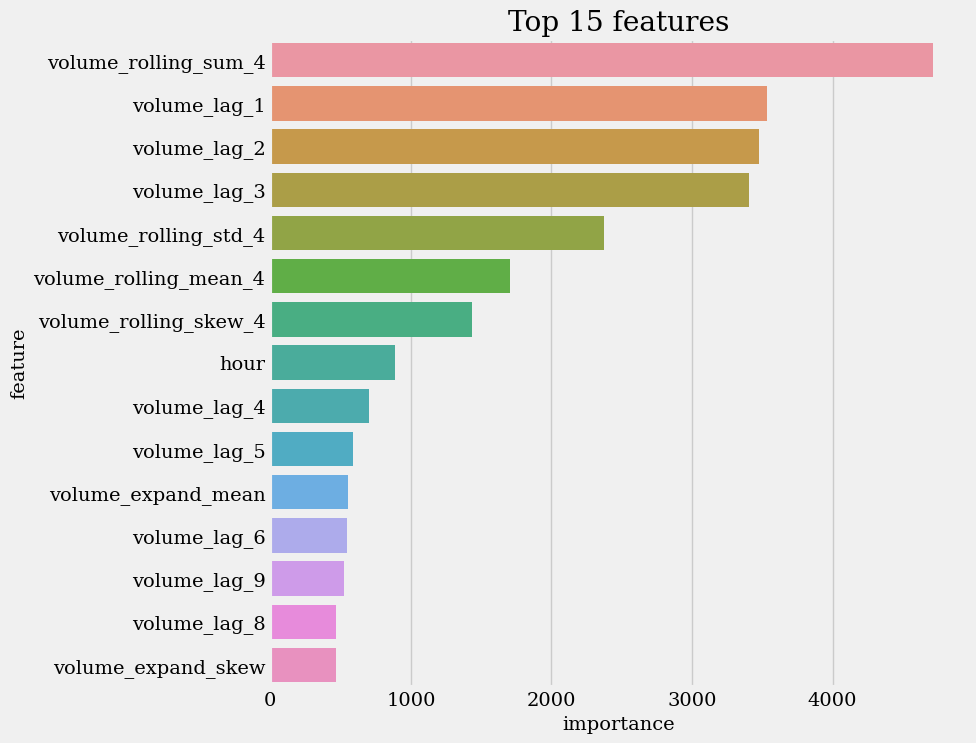

In [253]:
feature_importances = pd.DataFrame(
    {"feature": val_train[features].columns,
     "importance": reg.feature_importances_}
)

plt.figure(figsize=(8, 8))
sns.barplot(
    data=feature_importances.sort_values("importance", ascending=False).head(15),
    x="importance",
    y="feature",
)
plt.yticks(fontsize=14)
plt.title("Top 15 features")
plt.show()

## make test predictions

In [254]:
test['predicted_volume'] = reg.predict(test[features])
print("TEST MAE: {:.3f}".format(mean_absolute_error(test["volume"], test["predicted_volume"])))

TEST MAE: 0.247


One-Step MAE: 0.2468


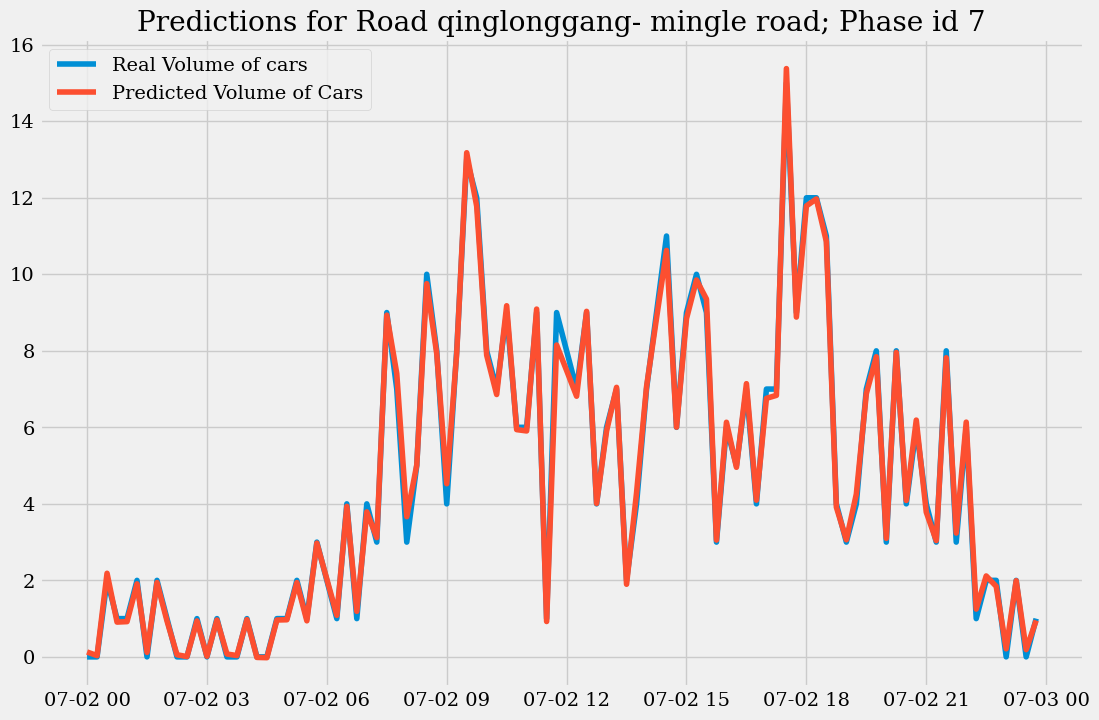

In [255]:
# recursive_x = df[['junction_name','junction_approach','veh_turn_dir','phase_id','volume']]

# forecast_ms = []
# for i in test.index.unique():
#     recursive_x = feature_engineering_pipeline(recursive_x)
#     tmp = recursive_x[recursive_x.index == i]
#     pred = reg.predict(tmp[features])
#     recursive_x.loc[recursive_x.index == i,'volume']= pred
#     forecast_ms.append(pred)
    
# forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = reg.predict(test[features])


tmp = test.copy()
tmp['os_predicted'] = forecast_os
# tmp['ms_predicted'] = forecast_ms_rec 

print('One-Step MAE: %.4f' % (mean_absolute_error(tmp['volume'],tmp['os_predicted'])))
#print('Multi-Step MAE: %.4f' % (mean_absolute_error(tmp['volume'],tmp['ms_predicted'])))

plt.figure(figsize=(12, 8))
#plt.plot(train[(train.junction_name=='青龙港路-民乐路') & (train.phase_id==7)][["volume"]])
plt.plot(tmp[(tmp.junction_name=='青龙港路-民乐路') & (tmp.phase_id==7)][["volume"]])
plt.plot(tmp[(tmp.junction_name=='青龙港路-民乐路') & (tmp.phase_id==7)][["os_predicted"]])
plt.title("Predictions for Road qinglonggang- mingle road; Phase id 7")
plt.legend(["Real Volume of cars",'Predicted Volume of Cars'])
plt.show()

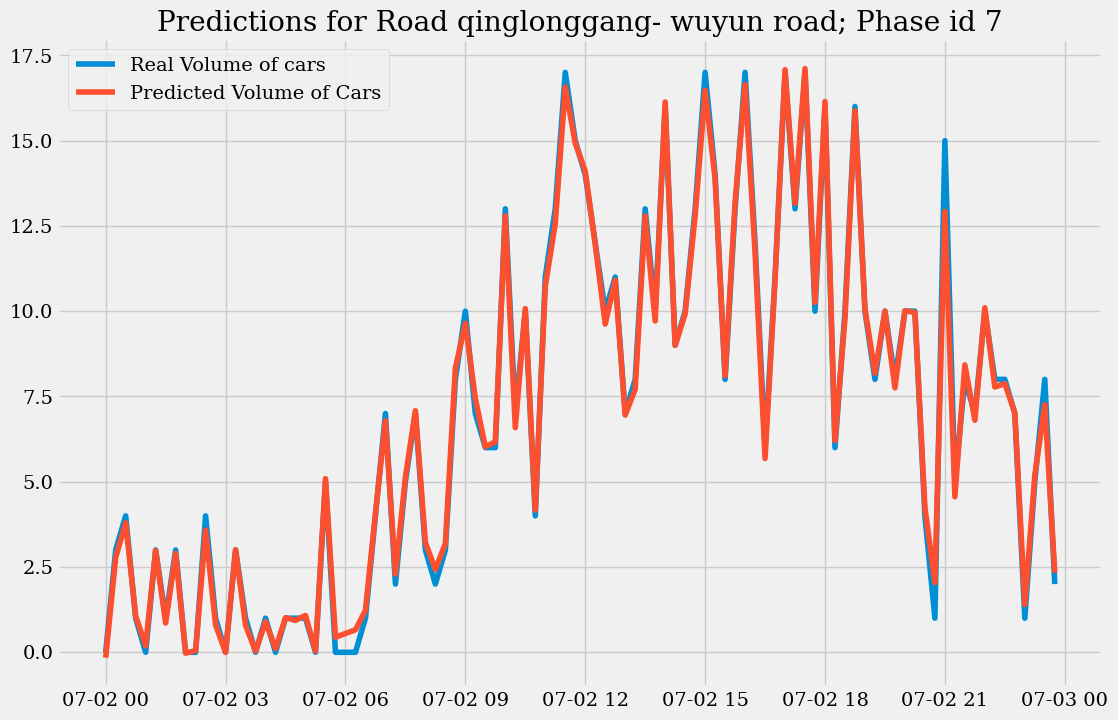

In [256]:
plt.figure(figsize=(12, 8))
#plt.plot(train[(train.junction_name=='青龙港路-民乐路') & (train.phase_id==7)][["volume"]])
plt.plot(tmp[(tmp.junction_name=='青龙港路-吴韵路') & (tmp.phase_id==7)][["volume"]])
plt.plot(tmp[(tmp.junction_name=='青龙港路-吴韵路') & (tmp.phase_id==7)][["os_predicted"]])
plt.title("Predictions for Road qinglonggang- wuyun road; Phase id 7")
plt.legend(["Real Volume of cars",'Predicted Volume of Cars'])
plt.show()

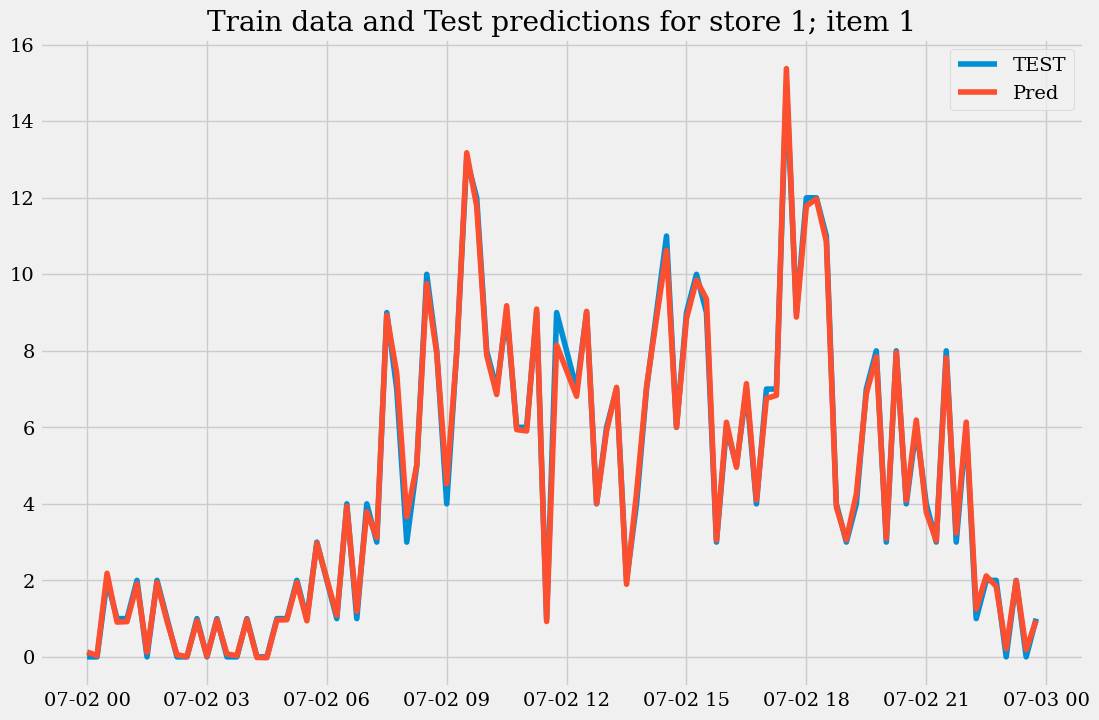

In [257]:
test["predicted_volume"] = reg.predict(test[features])
plt.figure(figsize=(12, 8))
#plt.plot(train[(train.junction_name=='青龙港路-民乐路') & (train.phase_id==7)][["volume"]])
plt.plot(test[(test.junction_name=='青龙港路-民乐路') & (test.phase_id==7)][["volume"]])
plt.plot(test[(test.junction_name=='青龙港路-民乐路') & (test.phase_id==7)][["predicted_volume"]])
plt.title("Train data and Test predictions for store 1; item 1")
plt.legend(["TEST",'Pred'])
plt.show()



In [258]:
df.head()

,junction_name,junction_approach,veh_turn_dir,phase_id,volume,hour,go_to_work_peak,go_back_home_peak,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,is_weekend,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,volume_lag_10,volume_lag_11,volume_lag_12,volume_rolling_sum_4,volume_rolling_mean_4,volume_rolling_std_4,volume_rolling_skew_4,volume_expand_mean,volume_expand_std,volume_expand_skew
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-12 00:00:00,北天成路-吴韵路,A,s,1,0,0,0,0,0,2,6,163,12,24,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-12 00:15:00,北天成路-吴韵路,A,s,1,0,0,0,0,0,2,6,163,12,24,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2023-06-12 00:30:00,北天成路-吴韵路,A,s,1,0,0,0,0,0,2,6,163,12,24,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023-06-12 00:45:00,北天成路-吴韵路,A,s,1,0,0,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-12 01:00:00,北天成路-吴韵路,A,s,1,0,1,0,0,0,2,6,163,12,24,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
df.volume.sum()/21

159077.14285714287

In [260]:
#159077
#1.5t 50%​

#2.5t 30%​

#3.5t 20%
volume_15t = int(159077*0.5)
volume_25t = int(159077*0.3)
volume_35t = int(159077*0.2)

In [261]:
volume_35t

31815

In [262]:
energy = pd.read_csv('energy.csv').dropna()

In [263]:
energy

,type,braking_type,energy_saved,percentage,volume
0,1.5,60_0,0.0386,0.3,79538.0
1,1.5,50_10,0.0190,0.5,79538.0
2,1.5,30_10,0.0058,0.2,79538.0
3,2.5,60_0,0.0640,0.3,47723.0
4,2.5,50_10,0.0320,0.5,47723.0
5,2.5,30_10,0.0096,0.2,47723.0
6,3.5,60_0,0.1070,0.3,31815.0
7,3.5,50_10,0.0560,0.5,31815.0
8,3.5,30_10,0.0130,0.2,31815.0


In [264]:
energy['total_energy_saved'] = energy['volume']*energy['percentage']*energy['energy_saved']

In [265]:
energy

,type,braking_type,energy_saved,percentage,volume,total_energy_saved
0,1.5,60_0,0.0386,0.3,79538.0,921.05004
1,1.5,50_10,0.0190,0.5,79538.0,755.61100
2,1.5,30_10,0.0058,0.2,79538.0,92.26408
3,2.5,60_0,0.0640,0.3,47723.0,916.28160
4,2.5,50_10,0.0320,0.5,47723.0,763.56800
5,2.5,30_10,0.0096,0.2,47723.0,91.62816
6,3.5,60_0,0.1070,0.3,31815.0,1021.26150
7,3.5,50_10,0.0560,0.5,31815.0,890.82000
8,3.5,30_10,0.0130,0.2,31815.0,82.71900


In [269]:
energy.total_energy_saved.sum()

5535.20338

In [272]:
test["predicted_volume"].mean()

11.964251277246545

In [273]:
test["volume"].mean()

11.955493998153278

In [275]:
(11.955493998153278 - 0.247)/11.955493998153278

0.9793400423237925